In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("bright")
import torch.nn
import random

In [5]:
df = pd.read_json("train.json")
df_test = pd.read_json("test.json")
print(len(df))
print(len(df_test))
df.head()

39774
9944


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [6]:
df["cuisine"].value_counts()

cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64

In [7]:
ingredients = df["ingredients"].tolist()
test_ingredients = df_test["ingredients"].tolist()
ingredients = ingredients + test_ingredients

In [8]:
ingredients_dict = {}
for recipe in ingredients:
    for ingredient in recipe:
        ingredients_dict[ingredient] = ingredients_dict.get(ingredient,0)+ 1

ing_df = pd.DataFrame(data = ingredients_dict.values(),index = ingredients_dict.keys(),columns = ["Counts"])
ing_df.sort_values(["Counts"],ascending = False, inplace = True)
ing_df

,Counts
salt,22534
onions,10008
olive oil,9889
water,9293
garlic,9171
...,...
seville orange juice,1
dried hibiscus blossoms,1
pancake batter,1
dairy free coconut ice cream,1


In [9]:
stopwords= ["fresh","chopped","large","all-purpose","grated","freshly","crushed","minced","skinless"
           "sodium","low","diced","unsalted","coarse","low-fat","medium","powdered","finely","fine",
           "pitted","plain","low-fat","full-fat","nonfat","fat-free"]
def find_occurence(word,recipe_list):
    #Utility function to check if an ingredient is present in the list of recipes
    result = {}
    for recipe in recipe_list:
        for ingredient in recipe:
            if word in ingredient:
                result[ingredient] = result.get(ingredient,0) + 1
    return list(result.keys())

ingredients2 = []
for index,i in enumerate(ingredients):
    recipe = []
    for j in i:
        ing_word = j.split(" ")
        ing_word = [i for i in ing_word if i not in stopwords]
        recipe.append(" ".join(ing_word))
    ingredients2.append(recipe)
ingredients = ingredients2[:]

ingredients_dict2 = {}
for recipe in ingredients:
    for ingredient in recipe:
        ingredients_dict2[ingredient] = ingredients_dict2.get(ingredient,0)+ 1
ing_df = pd.DataFrame(data = ingredients_dict2.values(),index = ingredients_dict2.keys(),columns = ["Counts"])
ing_df.sort_values(["Counts"],ascending = False, inplace = True)
df["ingredients"]= ingredients[:len(df)] #Append the "cleaned" list of ingredients to the dataframe
ingredients_map = {k:v for k,v in zip(ing_df.index,range(len(ing_df)))}

def convert_recipe(recipe):
    '''
    Convert Recipe from a List of String Ingredients to a Vector
    recipe: List of Ingredients
    output: 7137x1 Vector
    '''
    output = np.zeros(7137)
    for ingredient in recipe:
        output[ingredients_map[ingredient]] = 1
    return output

df["Vector"] = df["ingredients"].apply(convert_recipe)

In [10]:
mat = list(df["Vector"])
mat = np.array(mat)
mat.shape

(39774, 7137)

In [11]:
from sklearn.decomposition import PCA
pca = PCA(32)
mat_32 = pca.fit_transform(mat)

In [12]:
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mat_32,df['cuisine'],
                                                    test_size=0.30)
svc = SVC(kernel = "rbf")
svc.fit(X_train,y_train)

SVC()

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = svc.predict(X_test)
print(classification_report(y_test,predictions))
cr = classification_report(y_test,predictions,output_dict= True)

              precision    recall  f1-score   support

   brazilian       0.73      0.06      0.12       128
     british       0.64      0.03      0.06       223
cajun_creole       0.65      0.48      0.55       460
     chinese       0.57      0.71      0.63       796
    filipino       0.62      0.29      0.40       242
      french       0.38      0.21      0.27       805
       greek       0.53      0.15      0.23       384
      indian       0.73      0.77      0.75       895
       irish       0.36      0.04      0.08       204
     italian       0.58      0.83      0.68      2320
    jamaican       0.67      0.16      0.25       154
    japanese       0.51      0.31      0.39       435
      korean       0.69      0.26      0.38       251
     mexican       0.80      0.83      0.81      1938
    moroccan       0.69      0.47      0.56       264
     russian       0.70      0.05      0.10       132
 southern_us       0.36      0.65      0.46      1284
     spanish       0.47    

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [15]:
df = pd.concat([df,df_test]) # This is to train the Language Model on the entire set of ingredients

stopwords= ["fresh","chopped","large","all-purpose","grated","freshly","crushed","minced","skinless"
           "sodium","low","diced","unsalted","coarse","low-fat","medium","powdered","finely","fine",
           "pitted","plain","low-fat","full-fat","nonfat","fat-free"]
def find_occurence(word,recipe_list):
    result = {}
    for recipe in recipe_list:
        for ingredient in recipe:
            if word in ingredient:
                result[ingredient] = result.get(ingredient,0) + 1
    return list(result.keys())

ingredients2 = []
for index,i in enumerate(ingredients):
    recipe = []
    for j in i:
        ing_word = j.split(" ")
        ing_word = [i for i in ing_word if i not in stopwords]
        recipe.append(" ".join(ing_word))
    ingredients2.append(recipe)
ingredients = ingredients2[:]

ingredients_dict2 = {}
for recipe in ingredients2:
    for ingredient in recipe:
        ingredients_dict2[ingredient] = ingredients_dict2.get(ingredient,0)+ 1
ing_df = pd.DataFrame(data = ingredients_dict2.values(),index = ingredients_dict2.keys(),columns = ["Counts"])
ing_df.sort_values(["Counts"],ascending = False, inplace = True)
df["ingredients"]= ingredients[:len(df)] #Append the "cleaned" list of ingredients to the dataframe
ingredients_map = {k:v for k,v in zip(ing_df.index,range(len(ing_df)))}

def convert_recipe(recipe):
    '''
    Convert Recipe from a List of String Ingredients to a Vector
    recipe: List of Ingredients
    output: 7137x1 Vector
    '''
    output = np.zeros(7137)
    for ingredient in recipe:
        output[ingredients_map[ingredient]] = 1
    return output

df["Vector"] = df["ingredients"].apply(convert_recipe)

In [16]:
#Helper Functions
CONTEXT_SIZE = 5
#The sampling function to get context words from a recipe
def sample(recipe,ingredient,samples):
    '''
    Input: Recipe -> List of Ingredients
           Ingredient -> String
           Samples: Int for number of samples
    Output: List of Strings
    '''
    recipe = recipe[:] #Copy the recipe to prevent alteration
    recipe.remove(ingredient)
    if len(recipe) < CONTEXT_SIZE+1:
        context = random.choices(recipe, k=samples) #With Replacement when they are insufficient ingredients in the recipe
    else:
        context = random.sample(recipe, k=samples) #Without Replacement
    return context
def createTensor(context):
    idxs = [ingredients_map[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)
class RecipeDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [17]:
#Helper Functions
CONTEXT_SIZE = 5
#The sampling function to get context words from a recipe
def sample(recipe,ingredient,samples):
    '''
    Input: Recipe -> List of Ingredients
           Ingredient -> String
           Samples: Int for number of samples
    Output: List of Strings
    '''
    recipe = recipe[:] #Copy the recipe to prevent alteration
    recipe.remove(ingredient)
    if len(recipe) < CONTEXT_SIZE+1:
        context = random.choices(recipe, k=samples) #With Replacement when they are insufficient ingredients in the recipe
    else:
        context = random.sample(recipe, k=samples) #Without Replacement
    return context
def createTensor(context):
    idxs = [ingredients_map[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)
class RecipeDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [18]:
def loadData(dataCol,batch_size):
    samples = []
    for recipe in dataCol:
        for ingredient in recipe:
            if len(recipe) > 2:
                samples.append([sample(recipe,ingredient,CONTEXT_SIZE),ingredient])
    samples_idx = []
    for context,target in samples:
        target_idx = (torch.tensor([ingredients_map[target]], dtype=torch.long))
        samples_idx.append([createTensor(context),target_idx])

    sample_DS = RecipeDataset(samples_idx)
    train_loader = Data
    Loader(dataset=sample_DS, batch_size=batch_size, shuffle=True)
    return train_loader

In [19]:
VOCAB_SIZE = len(ingredients_dict2)
EMBED_DIM = 32

class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOWModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) #Transform to Lower Dimension Embeddings
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).sum(dim = 1) #Sum over all the context
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        return out
    def getEmbeds(self,wordIdx):
        return self.embeddings(wordIdx)

cbow = CBOWModel(VOCAB_SIZE,EMBED_DIM,CONTEXT_SIZE)

In [22]:
#Grid Search to find Ideal Learning Rate

l_rs = [0.1,0.25,0.5,1,2]
#Code to find ideal learning Rate for the model
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Removed the line causing the error: torch.cuda.set_device(0)
# The above line automatically selects the available CUDA device if any.
cbow.to(device)
loss_dict = {}
num_epochs = 25
train_loader= loadData(df["ingredients"],128)
criterion = torch.nn.CrossEntropyLoss()

BATCH_SIZE = 128
for l_r in l_rs:
    losses = []
    cbow = CBOWModel(VOCAB_SIZE,EMBED_DIM,CONTEXT_SIZE)
    cbow.to(device)
    optimizer = torch.optim.SGD(cbow.parameters(), lr=l_r)
    iter_ = 0
    print("Learning Rate:",l_r)
    for epoch in range(num_epochs):
        total_loss = 0
        for i,(context,target) in enumerate(train_loader):

            context = context.to(device)
            target =target.to(device)
            optimizer.zero_grad()
            outputs = cbow(context)
            target = target.view(-1)
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            iter_  += 1
            total_loss +=loss.item()
            if iter_%500 ==0:
                print("Progress:",iter_/(num_epochs*len(train_loader))*100,"%")

        losses.append(total_loss)
    loss_dict[l_r] = losses

Learning Rate: 0.1
Progress: 0.4783544606553456 %
Progress: 0.9567089213106912 %
Progress: 1.435063381966037 %
Progress: 1.9134178426213824 %
Progress: 2.391772303276728 %
Progress: 2.870126763932074 %
Progress: 3.3484812245874194 %
Progress: 3.8268356852427647 %
Progress: 4.305190145898111 %
Progress: 4.783544606553456 %
Progress: 5.261899067208802 %
Progress: 5.740253527864148 %
Progress: 6.218607988519493 %
Progress: 6.696962449174839 %
Progress: 7.175316909830184 %
Progress: 7.6536713704855295 %
Progress: 8.132025831140876 %
Progress: 8.610380291796222 %
Progress: 9.088734752451566 %
Progress: 9.567089213106913 %
Progress: 10.045443673762259 %
Progress: 10.523798134417603 %
Progress: 11.00215259507295 %
Progress: 11.480507055728296 %
Progress: 11.95886151638364 %
Progress: 12.437215977038987 %
Progress: 12.915570437694331 %
Progress: 13.393924898349677 %
Progress: 13.872279359005022 %
Progress: 14.350633819660368 %
Progress: 14.828988280315713 %
Progress: 15.307342740971059 %
Progr

In [21]:
#Helper Functions
CONTEXT_SIZE = 5
#The sampling function to get context words from a recipe
def sample(recipe,ingredient,samples):
    '''
    Input: Recipe -> List of Ingredients
           Ingredient -> String
           Samples: Int for number of samples
    Output: List of Strings
    '''
    recipe = recipe[:] #Copy the recipe to prevent alteration
    recipe.remove(ingredient)
    if len(recipe) < CONTEXT_SIZE+1:
        context = random.choices(recipe, k=samples) #With Replacement when they are insufficient ingredients in the recipe
    else:
        context = random.sample(recipe, k=samples) #Without Replacement
    return context
def createTensor(context):
    idxs = [ingredients_map[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)
class RecipeDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

#Import the required module
from torch.utils.data import DataLoader #Import the DataLoader class

def loadData(dataCol,batch_size):
    samples = []
    for recipe in dataCol:
        for ingredient in recipe:
            if len(recipe) > 2:
                samples.append([sample(recipe,ingredient,CONTEXT_SIZE),ingredient])
    samples_idx = []
    for context,target in samples:
        target_idx = (torch.tensor([ingredients_map[target]], dtype=torch.long))
        samples_idx.append([createTensor(context),target_idx])

    sample_DS = RecipeDataset(samples_idx)
    #Use the imported DataLoader class
    train_loader = DataLoader(dataset=sample_DS, batch_size=batch_size, shuffle=True)
    return train_loader

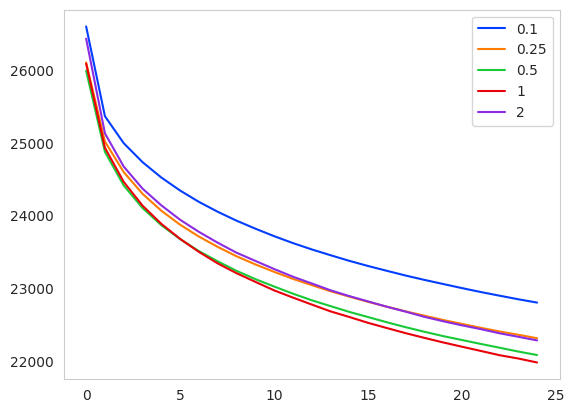

In [23]:
for l_r,losses in loss_dict.items():
    plt.plot(losses,label = l_r)
plt.legend()

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cbow = CBOWModel(VOCAB_SIZE,EMBED_DIM,CONTEXT_SIZE)
cbow.to(device)
losses = []
num_epochs = 80
iter_ = 0
BATCH_SIZE = 128
learning_rate = 1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    total_loss = 0
    if epoch%4 == 0:
        train_loader = loadData(df["ingredients"],BATCH_SIZE)
    for i,(context,target) in enumerate(train_loader):
        context = context.to(device)
        target =target.to(device)
        optimizer.zero_grad()
        outputs = cbow(context)
        target = target.view(-1)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        iter_  += 1
        total_loss +=loss.item()
        if iter_%500 ==0:
            print("Progress:",iter_/(num_epochs*len(train_loader))*100,"%")

    losses.append(total_loss)

print(losses)

Progress: 0.1494857689547955 %
Progress: 0.298971537909591 %
Progress: 0.4484573068643865 %
Progress: 0.597943075819182 %
Progress: 0.7474288447739775 %
Progress: 0.896914613728773 %
Progress: 1.0464003826835684 %
Progress: 1.195886151638364 %
Progress: 1.3453719205931596 %
Progress: 1.494857689547955 %
Progress: 1.6443434585027505 %
Progress: 1.793829227457546 %
Progress: 1.9433149964123417 %
Progress: 2.0928007653671368 %
Progress: 2.2422865343219325 %
Progress: 2.391772303276728 %
Progress: 2.5412580722315234 %
Progress: 2.690743841186319 %
Progress: 2.840229610141115 %
Progress: 2.98971537909591 %
Progress: 3.1392011480507054 %
Progress: 3.288686917005501 %
Progress: 3.438172685960297 %
Progress: 3.587658454915092 %
Progress: 3.7371442238698878 %
Progress: 3.8866299928246835 %
Progress: 4.036115761779479 %
Progress: 4.1856015307342735 %
Progress: 4.33508729968907 %
Progress: 4.484573068643865 %
Progress: 4.63405883759866 %
Progress: 4.783544606553456 %
Progress: 4.933030375508252 %

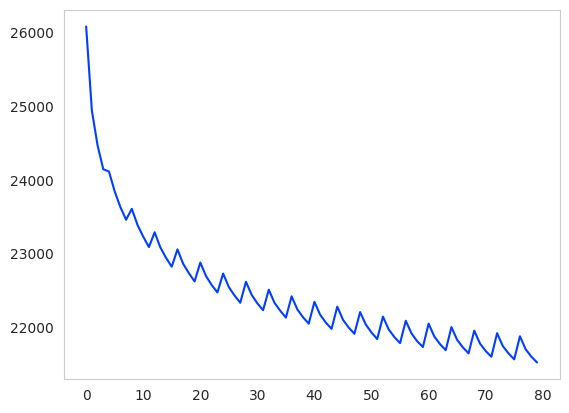

In [26]:
plt.plot(losses)

In [27]:
cbow.to("cpu")
df = df[df["cuisine"].notna()]
ing_tensor_list = df["ingredients"].apply(createTensor).tolist()
embed_array = []
for recipe in ing_tensor_list:
    embeds = cbow.getEmbeds(recipe)
    embeds = embeds.mean(axis = 0).detach().numpy()
    embed_array.append(embeds)

In [28]:
from sklearn.manifold import TSNE

In [29]:
embed_array = np.array(embed_array)
nlp_vis = TSNE(n_components= 2,perplexity= 40).fit_transform(embed_array)

In [30]:
set1 = list(df["cuisine"].value_counts().index[:10])
set2 = list(df["cuisine"].value_counts().index[10:])

In [31]:
mat_vis =TSNE(n_components= 2,perplexity= 40).fit_transform(mat_32)

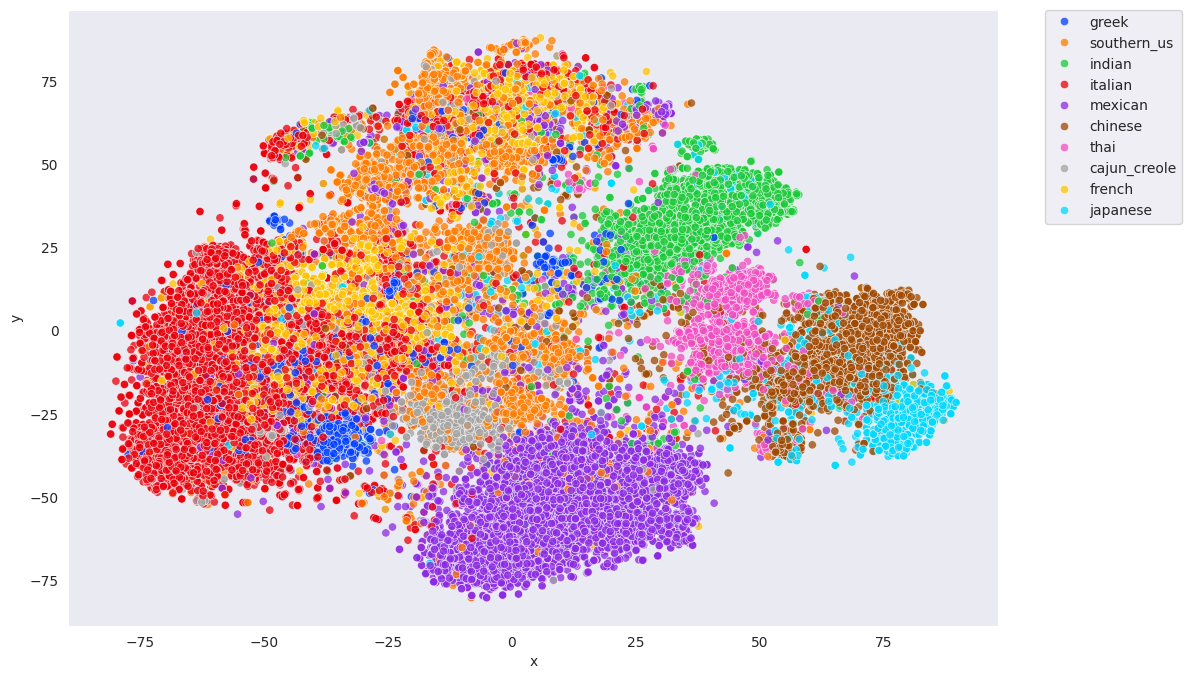

In [32]:
sns.set_style("dark")
fig,ax = plt.subplots(figsize = (12,8))
vis_df  = {"x":nlp_vis[:,0],"y" : nlp_vis[:,1],"target" : df["cuisine"]}
vis_df = pd.DataFrame(vis_df)
vis_df = vis_df[vis_df["target"].isin(set1)]
sns.scatterplot(data  = vis_df,x = "x",y="y",hue = "target",alpha = 0.75,palette=sns.color_palette("bright"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

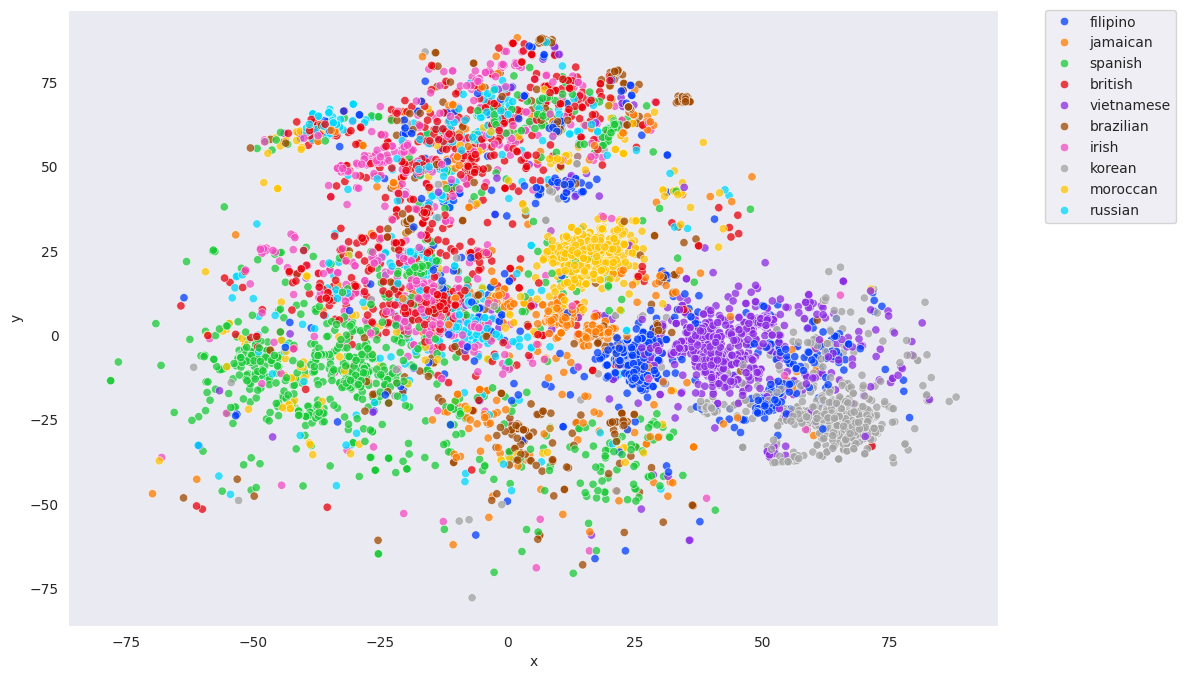

In [33]:
fig,ax = plt.subplots(figsize = (12,8))
vis_df  = {"x":nlp_vis[:,0],"y" : nlp_vis[:,1],"target" : df["cuisine"]}
vis_df = pd.DataFrame(vis_df)
vis_df = vis_df[vis_df["target"].isin(set2)]
sns.scatterplot(data  = vis_df,x = "x",y="y",hue = "target",alpha = 0.75,palette=sns.color_palette("bright"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

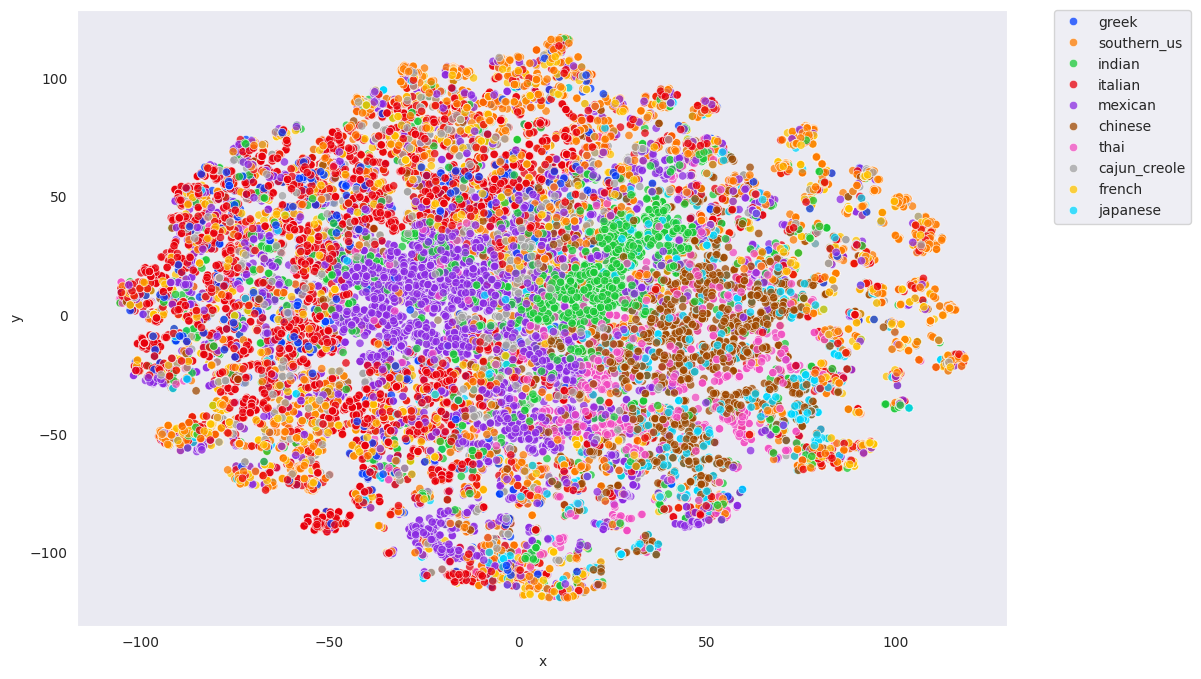

In [34]:
fig,ax = plt.subplots(figsize = (12,8))
vis_df  = {"x":mat_vis[:,0],"y" : mat_vis[:,1],"target" : df["cuisine"]}
vis_df = pd.DataFrame(vis_df)
vis_df = vis_df[vis_df["target"].isin(set1)]
sns.scatterplot(data  = vis_df,x = "x",y="y",hue = "target",alpha = 0.75,palette=sns.color_palette("bright"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

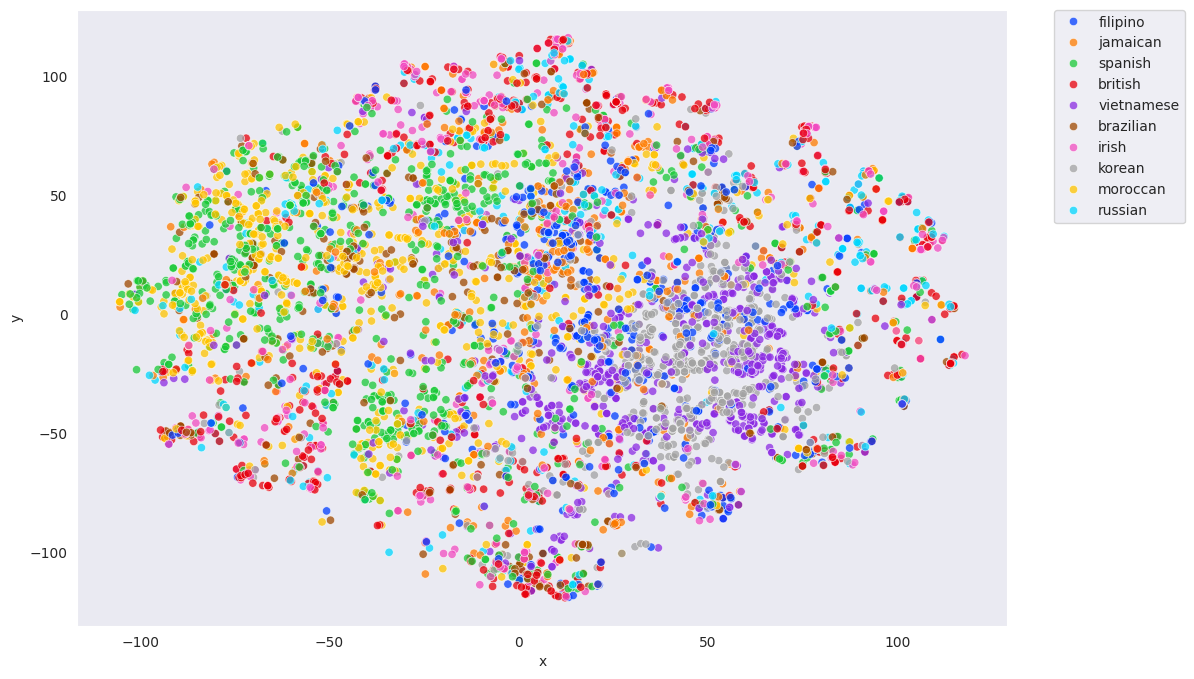

In [35]:
fig,ax = plt.subplots(figsize = (12,8))
vis_df  = {"x":mat_vis[:,0],"y" : mat_vis[:,1],"target" : df["cuisine"]}
vis_df = pd.DataFrame(vis_df)
vis_df = vis_df[vis_df["target"].isin(set2)]
sns.scatterplot(data  = vis_df,x = "x",y="y",hue = "target",alpha = 0.75,palette=sns.color_palette("bright"))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [36]:
def getRecipeEmbedding(OH_tensor):
    return cbow.getEmbeds(OH_tensor).mean(axis =0).detach().numpy()
df["Tensor"] = df["ingredients"].apply(createTensor)
df["Embeds"] = df["Tensor"].apply(getRecipeEmbedding)

In [37]:
mat_embeds = list(df["Embeds"])
mat_embeds = np.array(mat_embeds)

X_train, X_test, y_train, y_test = train_test_split(mat_embeds,df['cuisine'],
                                                    test_size=0.30)
svc = SVC(kernel = "rbf")
svc.fit(X_train,y_train)

SVC()

In [38]:
predictions = svc.predict(X_test)
print(classification_report(y_test,predictions))
cr = classification_report(y_test,predictions,output_dict= True)

              precision    recall  f1-score   support

   brazilian       0.86      0.44      0.59       124
     british       0.56      0.29      0.38       261
cajun_creole       0.72      0.65      0.68       471
     chinese       0.78      0.86      0.82       818
    filipino       0.72      0.57      0.63       244
      french       0.54      0.59      0.56       792
       greek       0.75      0.60      0.67       356
      indian       0.85      0.89      0.87       907
       irish       0.73      0.33      0.46       200
     italian       0.77      0.89      0.82      2438
    jamaican       0.77      0.39      0.51       145
    japanese       0.81      0.63      0.71       405
      korean       0.81      0.69      0.74       230
     mexican       0.89      0.91      0.90      1891
    moroccan       0.83      0.70      0.76       273
     russian       0.54      0.32      0.40       136
 southern_us       0.64      0.79      0.71      1293
     spanish       0.51    